# Segmenting and Clustering Neighborhoods in Toronto

#### Importing all required packages

In [1]:
import numpy as np 
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests # library to handle requests
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import seaborn as sns
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Get the CSV data having postal and Geo codes in it.

In [2]:
postal_geo_df = pd.read_csv('canada_geo_postal_data.csv')
postal_geo_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Define Foursquare Credentials and Version

In [3]:
CLIENT_ID = 'K2XHN5JGEUJCU4BPB1YNDZ2AVNCYLUD3XPNA0DPGOIULVUFP' # your Foursquare ID
CLIENT_SECRET = 'XTV3DQUBBH0HNRXOG4HBMQCM04XSEF2LPDSLA3EJAZ0POCTZ' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 30
REDIRECT_URI = 'https://www.google.com'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K2XHN5JGEUJCU4BPB1YNDZ2AVNCYLUD3XPNA0DPGOIULVUFP
CLIENT_SECRET:XTV3DQUBBH0HNRXOG4HBMQCM04XSEF2LPDSLA3EJAZ0POCTZ


In [4]:
# Dropping Postal codes from, dataframe
postal_geo_df.drop(columns = 'Postal Code',inplace=True)
postal_geo_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


#### Use geopy library to get the latitude and longitude values of Toronto

In [5]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Toronto'

geolocator = Nominatim(user_agent="canada_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {} using geopy.'.format(latitude, longitude))
print('The geograpical coordinate of Toronto City are {}, {} using mean of lat and lat from postal_geo_df .'\
      .format(postal_geo_df.Latitude.mean(), postal_geo_df.Longitude.mean()))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347 using geopy.
The geograpical coordinate of Toronto City are 43.70460773398059, -79.39715291165048 using mean of lat and lat from postal_geo_df .


#### Create a map of Toronto with neighborhoods superimposed on top.

In [6]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
iterator = zip(postal_geo_df['Latitude'], postal_geo_df['Longitude'],
                postal_geo_df['Borough'], postal_geo_df['Neighborhood'])
for lat, lng, borough, neighborhood in iterator:
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Explore neighborhoods in Toronto.

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        while True:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                continue
            
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [8]:
toronto_venues = getNearbyVenues( \
    names=postal_geo_df['Neighborhood'], \
    latitudes=postal_geo_df['Latitude'], \
    longitudes=postal_geo_df['Longitude'] )

toronto_venues.to_csv('toronto_venues.csv', index=False)
toronto_venues = pd.read_csv('toronto_venues.csv')

Malvern , Rouge
Rouge Hill , Port Union , Highland Creek
Guildwood , Morningside , West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park , Ionview , East Birchmount Park
Golden Mile , Clairlea , Oakridge
Cliffside , Cliffcrest , Scarborough Village West
Birch Cliff , Cliffside West
Dorset Park , Wexford Heights , Scarborough Town Centre
Wexford , Maryvale
Agincourt
Clarks Corners , Tam O'Shanter , Sullivan
Milliken , Agincourt North , Steeles East , L'Amoreaux East
Steeles West , L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview , Henry Farm , Oriole
Bayview Village
York Mills , Silver Hills
Willowdale , Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor , Wilson Heights , Downsview North
Northwood Park , York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill , Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West , Riverdale
India Bazaar , The Beaches 

#### Let's check the size of the resulting dataframe

In [9]:
print(toronto_venues.shape)
toronto_venues.head()

(2172, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern , Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern , Rouge",43.806686,-79.194353,T Hamilton & Son Roofing Inc,43.807985,-79.198194,Construction & Landscaping
2,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
3,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
4,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar


Let's check how many venues were returned for each neighborhood

In [10]:
venue_counts = toronto_venues.groupby('Neighborhood').count()
venue_counts

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood , Long Branch",10,10,10,10,10,10
"Bathurst Manor , Wilson Heights , Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",28,28,28,28,28,28
Berczy Park,56,56,56,56,56,56
"Birch Cliff , Cliffside West",4,4,4,4,4,4
"Brockton , Parkdale Village , Exhibition Place",22,22,22,22,22,22
Business reply mail Processing CentrE,18,18,18,18,18,18


#### Let's look at the distribution of Venues

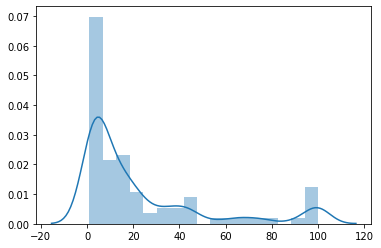

In [11]:
sns.distplot(venue_counts);

#### Let's find out how many unique categories can be curated from all the returned venues

In [12]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


## Analyze Each Neighborhood

In [13]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + [_ for _ in toronto_onehot.columns if _ !='Neighborhood']
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern , Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [14]:
# new dataframe size
toronto_onehot.shape

(2172, 273)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [15]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.

#### Let's confirm the new size

In [16]:
toronto_grouped.shape

(96, 273)

#### Let's print each neighborhood along with the top 5 most common venues

In [17]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1                     Lounge   0.2
2             Breakfast Spot   0.2
3               Skating Rink   0.2
4             Clothing Store   0.2


----Alderwood , Long Branch----
          venue  freq
0   Pizza Place   0.2
1           Gym   0.1
2      Pharmacy   0.1
3  Skating Rink   0.1
4   Coffee Shop   0.1


----Bathurst Manor , Wilson Heights , Downsview North----
            venue  freq
0            Bank  0.10
1     Coffee Shop  0.10
2  Ice Cream Shop  0.05
3   Shopping Mall  0.05
4  Sandwich Place  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.25
4        Movie Theater  0.00


----Bedford Park , Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.11
1      Sandwich Place  0.07
2         Coffee Shop  0.07
3     Thai Restaurant  0.07
4          Restau

              venue  freq
0               Bar  0.14
1        Restaurant  0.07
2              Café  0.05
3  Asian Restaurant  0.05
4       Coffee Shop  0.05


----Malvern , Rouge----
                             venue  freq
0             Fast Food Restaurant   0.5
1       Construction & Landscaping   0.5
2                    Metro Station   0.0
3  Molecular Gastronomy Restaurant   0.0
4       Modern European Restaurant   0.0


----Milliken , Agincourt North , Steeles East , L'Amoreaux East----
                             venue  freq
0                             Park   0.5
1                       Playground   0.5
2                Accessories Store   0.0
3                    Metro Station   0.0
4  Molecular Gastronomy Restaurant   0.0


----Mimico NW , The Queensway West , South of Bloor , Kingsway Park South West , Royal York South West----
                    venue  freq
0          Hardware Store  0.07
1  Thrift / Vintage Store  0.07
2          Discount Store  0.07
3          Sandwich

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = \
    return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood , Long Branch",Pizza Place,Gym,Sandwich Place,Dance Studio,Pub,Pool,Skating Rink,Pharmacy,Coffee Shop,Deli / Bodega
2,"Bathurst Manor , Wilson Heights , Downsview North",Bank,Coffee Shop,Middle Eastern Restaurant,Pharmacy,Sushi Restaurant,Deli / Bodega,Diner,Restaurant,Fried Chicken Joint,Ice Cream Shop
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park , Lawrence Manor East",Italian Restaurant,Thai Restaurant,Restaurant,Coffee Shop,Sandwich Place,Juice Bar,Japanese Restaurant,Fast Food Restaurant,Indian Restaurant,Pub


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [20]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# ValueError: cannot insert Cluster Labels, already exists

toronto_merged = postal_geo_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Malvern , Rouge",43.806686,-79.194353,1.0,Fast Food Restaurant,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
1,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,1.0,History Museum,Golf Course,Bar,Home Service,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711,1.0,Rental Car Location,Electronics Store,Breakfast Spot,Bank,Mexican Restaurant,Medical Center,Intersection,Dog Run,Discount Store,Distribution Center
3,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Indian Restaurant,Korean Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Lounge,Bank,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Hakka Restaurant,Bakery,Dumpling Restaurant


Finally, let's visualize the resulting clusters

In [25]:
# create map
map_clusters = folium.Map(location=[postal_geo_df.Latitude.mean(),
                                   postal_geo_df.Longitude.mean()], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

#### Cluster 1

In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,York Mills West,Park,Bank,Convenience Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dessert Shop,Donut Shop
25,Parkwoods,Park,Food & Drink Shop,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
40,East Toronto,Park,Coffee Shop,Convenience Store,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store
44,Lawrence Park,Park,Bus Line,Swim School,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dessert Shop
50,Rosedale,Park,Playground,Trail,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
74,Caledonia-Fairbanks,Park,Market,Women's Store,Golf Course,Ethiopian Restaurant,Gourmet Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
90,"The Kingsway , Montgomery Road , Old Mill North",Park,River,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space
98,Weston,Park,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


#### Cluster 2

In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern , Rouge",Fast Food Restaurant,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
1,"Rouge Hill , Port Union , Highland Creek",History Museum,Golf Course,Bar,Home Service,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,"Guildwood , Morningside , West Hill",Rental Car Location,Electronics Store,Breakfast Spot,Bank,Mexican Restaurant,Medical Center,Intersection,Dog Run,Discount Store,Distribution Center
3,Woburn,Coffee Shop,Indian Restaurant,Korean Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,Cedarbrae,Lounge,Bank,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Hakka Restaurant,Bakery,Dumpling Restaurant
6,"Kennedy Park , Ionview , East Birchmount Park",Coffee Shop,Playground,Department Store,Chinese Restaurant,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
7,"Golden Mile , Clairlea , Oakridge",Bus Line,Bakery,Soccer Field,Ice Cream Shop,Metro Station,Intersection,Park,Gay Bar,Gastropub,Eastern European Restaurant
8,"Cliffside , Cliffcrest , Scarborough Village West",American Restaurant,Motel,Movie Theater,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio
9,"Birch Cliff , Cliffside West",College Stadium,Skating Rink,Café,General Entertainment,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
10,"Dorset Park , Wexford Heights , Scarborough To...",Indian Restaurant,Chinese Restaurant,Pet Store,Light Rail Station,Vietnamese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


#### Cluster 3

In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"York Mills , Silver Hills",Cafeteria,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio,Dessert Shop


#### Cluster 4

In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,"West Deane Park , Princess Gardens , Martin Gr...",Golf Course,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


#### Cluster 5

In [30]:

toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough Village,Playground,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
14,"Milliken , Agincourt North , Steeles East , L'...",Park,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
